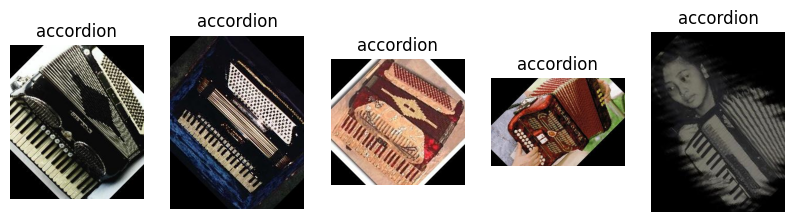

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 데이터셋 경로
dataset_path = r'C:\ex\caltech-101\caltech-101\101_ObjectCategories\101_ObjectCategories'  # Caltech 101 데이터셋 경로로 수정

# 데이터셋에서 이미지 로드
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

# 클래스 폴더 목록 가져오기
class_names = os.listdir(dataset_path)
images = {}

for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        images[class_name] = load_images_from_folder(class_folder)

# 예시로 첫 번째 클래스의 이미지를 시각화
first_class = class_names[0]
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(images[first_class][i], cv2.COLOR_BGR2RGB))
    plt.title(first_class)
    plt.axis('off')
plt.show()


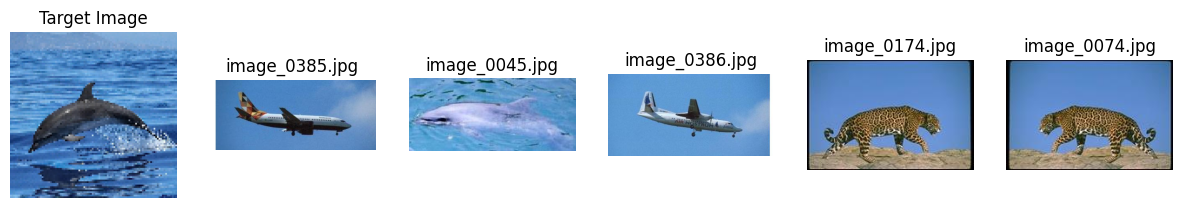

In [2]:
# knn

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 데이터셋 경로
dataset_path = r'C:\ex\caltech-101\caltech-101\101_ObjectCategories\101_ObjectCategories'  # Caltech 101 데이터셋 경로로 수정
# 비교할 이미지 경로로 수정
target_image_path = 'dolphin_test.jpg'

# 이미지 로드 함수
def load_images_from_folder(folder):
    images = []
    image_names = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            image_names.append(filename)
    return images, image_names

# 데이터셋에서 모든 이미지 로드
all_images = []
image_names = []
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        images, names = load_images_from_folder(class_folder)
        all_images.extend(images)
        image_names.extend(names)

# 특징 추출 함수 (간단히 색 히스토그램 사용)
def extract_features(images):
    features = []
    for img in images:
        # 이미지를 RGB로 변환하고, 크기를 100x100으로 조정
        img = cv2.resize(img, (100, 100))
        # 색 히스토그램 계산
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()  # 정규화
        features.append(hist)
    return np.array(features)

# 모든 이미지에 대해 특징 추출
features = extract_features(all_images)

# 비교할 이미지 로드 및 특징 추출
target_image = cv2.imread(target_image_path)
target_image = cv2.resize(target_image, (100, 100))
target_hist = cv2.calcHist([target_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
target_hist = cv2.normalize(target_hist, target_hist).flatten()

# KNN 모델을 사용하여 유사 이미지 검색
nbrs = NearestNeighbors(n_neighbors=5, metric='euclidean').fit(features)
distances, indices = nbrs.kneighbors([target_hist])

# 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 6, 1)
plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
plt.title('Target Image')
plt.axis('off')

for i in range(5):
    plt.subplot(1, 6, i + 2)
    plt.imshow(cv2.cvtColor(all_images[indices[0][i]], cv2.COLOR_BGR2RGB))
    plt.title(image_names[indices[0][i]])
    plt.axis('off')

plt.show()


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


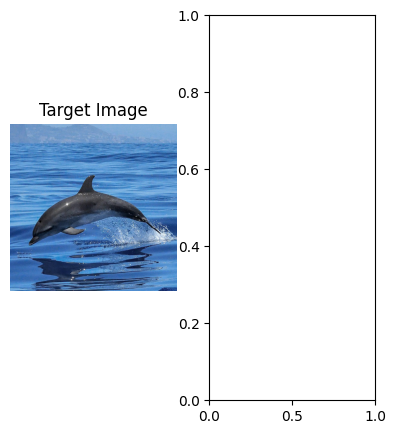

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# # 데이터셋 경로
# dataset_path = 'path_to_caltech101'  # Caltech 101 데이터셋 경로로 수정
# target_image_path = 'path_to_target_image.jpg'  # 비교할 이미지 경로로 수정
# 데이터셋 경로
dataset_path = r'C:\ex\caltech-101\caltech-101\101_ObjectCategories\101_ObjectCategories'  # Caltech 101 데이터셋 경로로 수정
# 비교할 이미지 경로로 수정
target_image_path = 'dolphin_test.jpg'

# SIFT 객체 생성
sift = cv2.SIFT_create()

# 이미지 로드 및 특징 추출 함수
def extract_sift_features(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    return keypoints, descriptors

# 비교할 이미지에서 특징 추출
target_keypoints, target_descriptors = extract_sift_features(target_image_path)

# 데이터셋에서 모든 이미지에 대해 특징 추출
all_descriptors = []
image_names = []
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            _, descriptors = extract_sift_features(img_path)
            if descriptors is not None:
                all_descriptors.append(descriptors)
                image_names.append(filename)

# BFMatcher를 사용하여 유사 이미지 찾기
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
similarities = []

for idx, desc in enumerate(all_descriptors):
    matches = bf.match(target_descriptors, desc)
    similarities.append((len(matches), idx))

# 유사도에 따라 정렬
similarities = sorted(similarities, key=lambda x: x[0], reverse=True)
top_matches_indices = [similarities[i][1] for i in range(5)]

# 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 6, 1)
plt.imshow(cv2.cvtColor(cv2.imread(target_image_path), cv2.COLOR_BGR2RGB))
plt.title('Target Image')
plt.axis('off')

for i, idx in enumerate(top_matches_indices):
    matched_image_path = os.path.join(dataset_path, image_names[idx])
    plt.subplot(1, 6, i + 2)
    plt.imshow(cv2.cvtColor(cv2.imread(matched_image_path), cv2.COLOR_BGR2RGB))
    plt.title(image_names[idx])
    plt.axis('off')

plt.show()